# Unsupervised setting: state discovery
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/paper_experiments/paper_1_unsupervised.ipynb)

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXPERIMENT', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))
    
# IMPORT PACKAGES
import torch
import lightning as pl

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

# IMPORT from mlcolvar 
from mlcolvar.data import DictModule
from mlcolvar.core.transform import Normalization,Statistics
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
from mlcolvar.utils.plot import muller_brown_potential_three_states, plot_isolines_2D, plot_metrics
from mlcolvar.utils.trainer import MetricsCallback

# IMPORT utils functions fo input generation
from utils.generate_input import gen_input_md,gen_input_md_potential,gen_plumed 

# Set seed for reproducibility
torch.manual_seed(42)

# ============================ SIMULATIONS VARIABLES ================================
run_calculations = False

if run_calculations:
    # plumed setup
    PLUMED_SOURCE = '/home/etrizio@iit.local/Bin/dev/plumed2-dev/sourceme.sh'
    PLUMED_EXE = f'source {PLUMED_SOURCE} && plumed'
    PLUMED_VES_MD = f"{PLUMED_EXE} ves_md_linearexpansion < input_md.dat"

    #test plumed
    subprocess.run(f"{PLUMED_EXE}", shell=True, executable='/bin/bash')

/Users/luigi/opt/anaconda3/envs/pytorch13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### System: modified Muller Brown potential

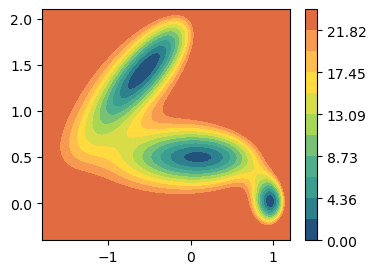

In [2]:
fig, ax = plt.subplots(figsize=(4,3))
plot_isolines_2D(muller_brown_potential_three_states, levels=np.linspace(0,24, 12), max_value=24, ax=ax)
MULLER_BROWN_FORMULA='0.15*(146.7-280*exp(-15*(x-1)^2+0*(x-1)*(y-0)-10*(y-0)^2)-170*exp(-1*(x-0.2)^2+0*(x-0)*(y-0.5)-10*(y-0.5)^2)-170*exp(-6.5*(x+0.5)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(x+1)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2))'

## Autoencoder CV definition
We start from information limited to state A (top left) and try to explore the rest of the world iteratively building autoencoder CVs on a progressively increasing dataset.

In [3]:
from mlcolvar.cvs import AutoEncoderCV

### Training Functions
As we will procede iteratively we define auxiliary funcitons for the different stages of the procedure to be used in a loop

#### Load Data

In [4]:
def load_data(filenames):
    # load dataset
    dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'}, create_labels=False, verbose=False)

    # create datamodule for trainer
    datamodule = DictModule(dataset,lengths=[0.8,0.2])
    return datamodule, dataset, df

def plot_training_points(df, iter_folder, iter):
    fig,ax = plt.subplots(figsize=(4,3))
    plot_isolines_2D(muller_brown_potential_three_states,mode='contour',levels=np.linspace(0,24,12),ax=ax)
    df.plot.scatter('p.x','p.y',s=1,cmap='fessa',ax=ax)
    ax.set_title(f'Training set - {iter}')
    plt.savefig(f'{iter_folder}/training_set.png')
    plt.show()

#### Define autoencoder model

In [5]:
def ae_model(encoder_layers):
    nn_args = {'activation': 'shifted_softplus'}
    options= {'encoder': nn_args, 'decoder': nn_args }
    model = AutoEncoderCV (encoder_layers, options=options )
    return model

#### Define Trainer & Fit

In [6]:
def ae_trainer(model, datamodule, iter):
    # define callbacks
    metrics = MetricsCallback()
    early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=10)
    # define trainer
    trainer = pl.Trainer(accelerator='cuda',callbacks=[metrics, early_stopping], max_epochs=10000,
                         enable_checkpointing=False, enable_model_summary=False)
    # fit
    trainer.fit( model, datamodule )
    return metrics

Normalize output after training

In [7]:
def ae_normalization(model, dataset, n_components):
    X = dataset[:]['data']
    with torch.no_grad():
        model.postprocessing = None # reset  
        s = model(torch.Tensor(X))

    norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) ) 
    model.postprocessing = norm
    return model

#### Analysis of the CV

In [8]:
def ae_cv_isolines(model, n_components, iter_folder, iter):
    fig,axs = plt.subplots( 1, n_components, figsize=(4*n_components,3) )
    if n_components == 1:
        axs = [axs]
    for i in range(n_components):
        ax = axs[i]
        plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour',ax=ax)
        plot_isolines_2D(model, component=i, levels=25, ax=ax)
        plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)
    ax.set_title(f'CV isolines - {iter}')
    plt.savefig(f'{iter_folder}/cv_isolines.png')
    plt.show()

#### Run plumed simulation

In [9]:
def ae_run_plumed(iter, iter_folder, initial_position, nsteps, ):
    # create folder
    SIMULATION_FOLDER = f'{iter_folder}/data'
    subprocess.run(f"mkdir {SIMULATION_FOLDER}", shell=True)

    # generate inputs
    gen_plumed(model_name=f'model_autoencoder_{iter}.pt', 
            file_path=SIMULATION_FOLDER, 
            potential_formula=MULLER_BROWN_FORMULA, 
            opes_mode='OPES_METAD')
    gen_input_md(inital_position=initial_position, file_path=SIMULATION_FOLDER, nsteps=nsteps)
    gen_input_md_potential(file_path=SIMULATION_FOLDER)

    subprocess.run(f'{PLUMED_EXE} ves_md_linearexpansion < input_md.dat', cwd=SIMULATION_FOLDER, shell=True, executable='/bin/bash')
    last_conf = load_dataframe(f'{SIMULATION_FOLDER}/COLVAR').iloc[-1][['p.x', 'p.y']].values
    return last_conf, SIMULATION_FOLDER

#### Visualize sampling

In [10]:
def ae_visualize_sampling(simulation_folder, iter):
    data = load_dataframe(f'{simulation_folder}/COLVAR')
    first_conf = data.iloc[0][['p.x', 'p.y']].values
    last_conf = data.iloc[-1][['p.x', 'p.y']].values
    fig, ax = plt.subplots(figsize=(4,3))
    data.plot.hexbin('p.x', 'p.y', C='opes.bias',cmap='fessa', ax=ax)
    ax.scatter(first_conf[0], first_conf[1], s=20, c='cyan')
    ax.scatter(last_conf[0], last_conf[1], s=20, c='magenta')
    ax.set_title(f'Sampling - {iter}')
    plt.savefig(f'{simulation_folder}/sampling.png')
    plt.show()

### Summary functions
These functions will load and summarize the data from already performed iterations

In [11]:
def load_training_data(iter):
    data = pd.DataFrame()
    for i in range(0,iter,1):
        temp = load_dataframe(f'{RESULTS_FOLDER}/iter_{i}/data/COLVAR')
        temp['iter'] = i +1
        data = pd.concat((data, temp), ignore_index=True)
    return data

def plot_iter_summary(iter, train, sampling):
    model = torch.jit.load(f'{RESULTS_FOLDER}/iter_{iter}/model_autoencoder_{iter}.pt') 

    fig, axs = plt.subplots(1,3, figsize=(12,4))

    ax = axs[0]
    ax.set_title(f'Training set - {iter}')
    plot_isolines_2D(muller_brown_potential_three_states,mode='contour',levels=np.linspace(0,24,12),ax=ax)
    train.plot.scatter('p.x', 'p.y', s=5, ax = ax)

    ax = axs[1]
    ax.set_title(f'CV isolines - {iter}')
    plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=0, levels=25, ax=ax, colorbar=False)
    plot_isolines_2D(model, component=0, mode='contour', levels=25, ax=ax)

    ax = axs[2]
    ax.set_title(f'Sampling - {iter}')
    plot_isolines_2D(muller_brown_potential_three_states,mode='contour',levels=np.linspace(0,24,12),ax=ax)
    ax.scatter(sampling['p.x'], sampling['p.y'], c=sampling['opes.bias'], s=5, cmap='fessa')

    plt.tight_layout()
    plt.show()
    

## Iterations: training and sampling

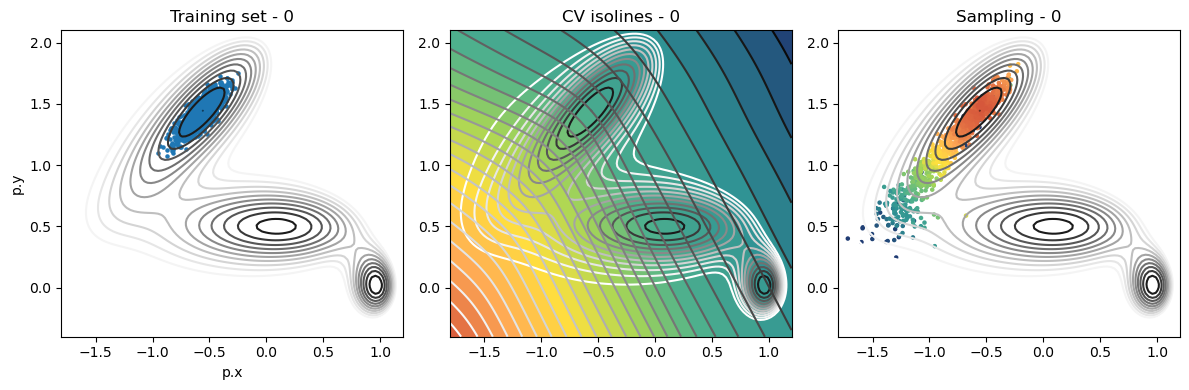

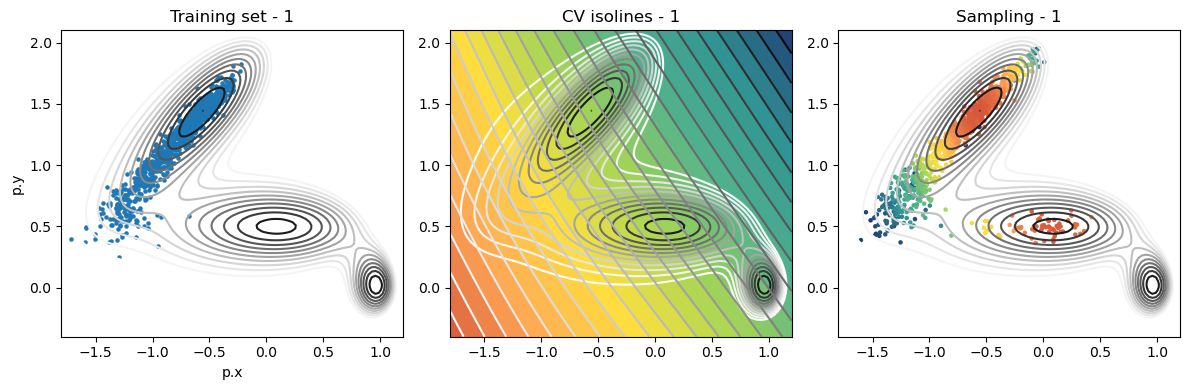

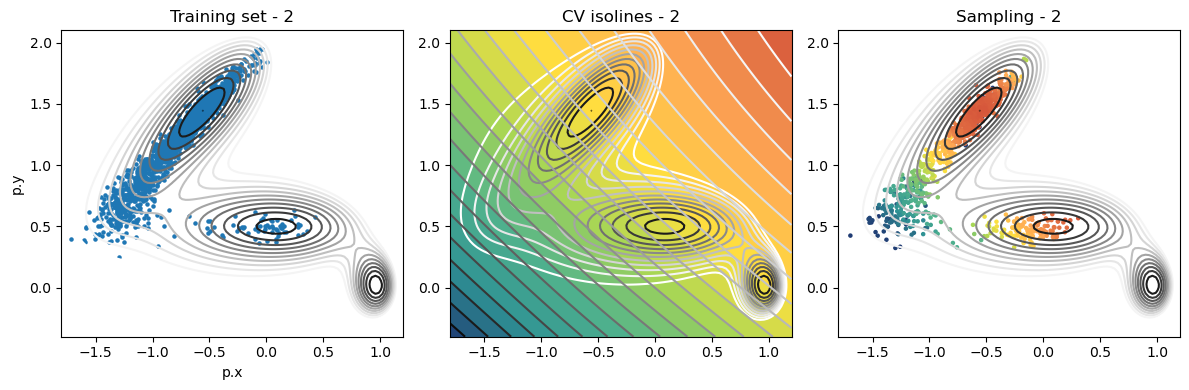

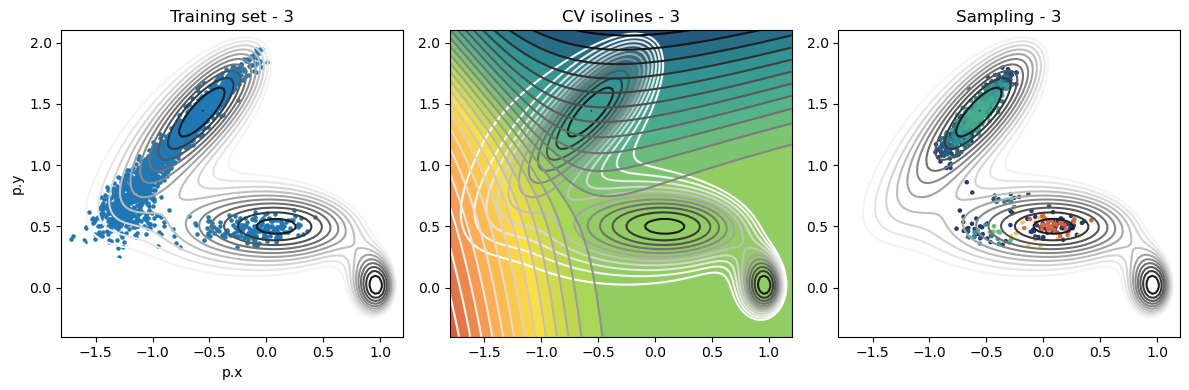

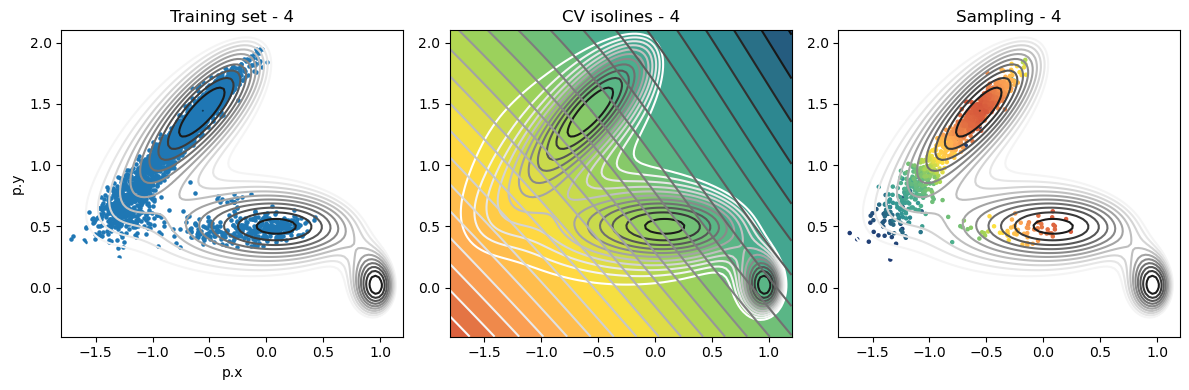

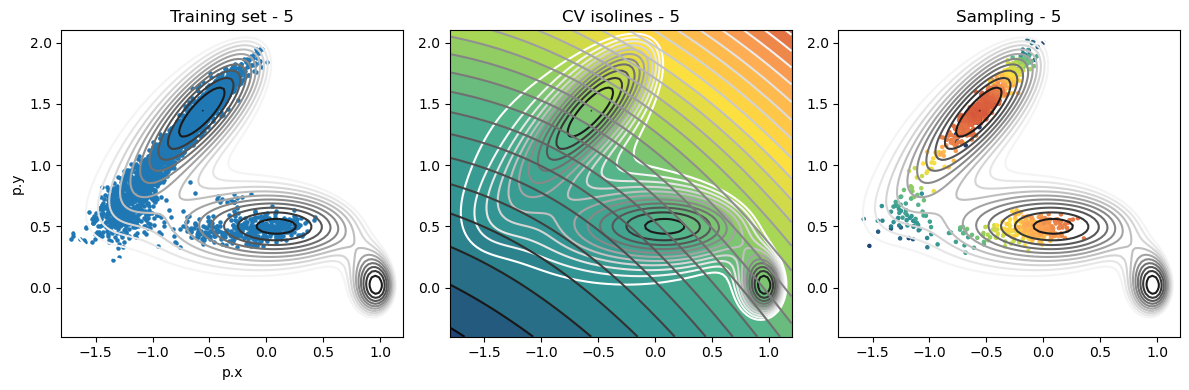

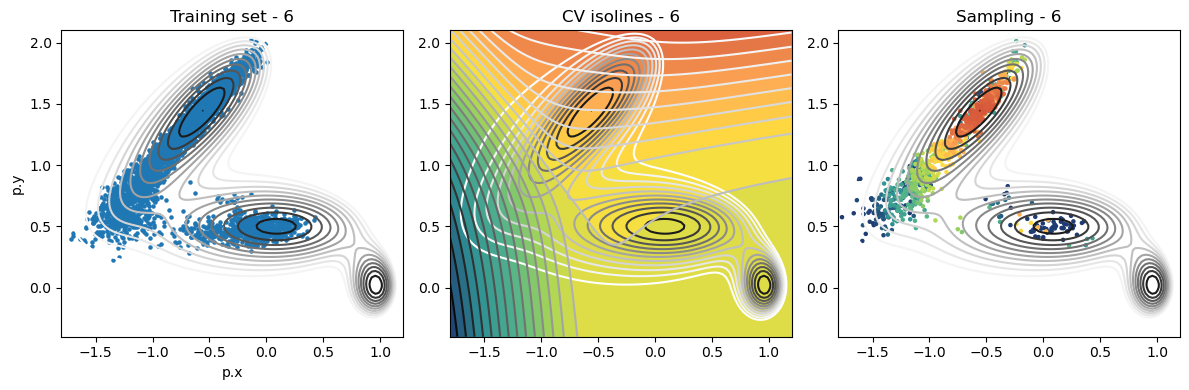

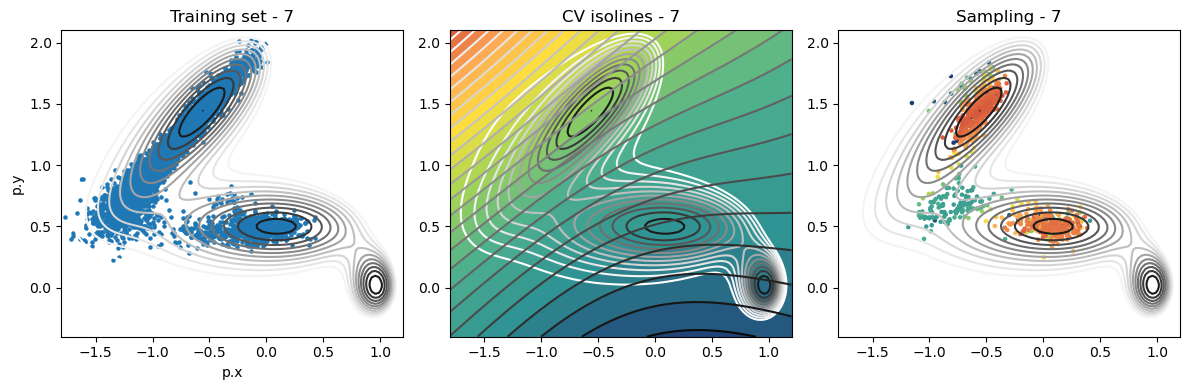

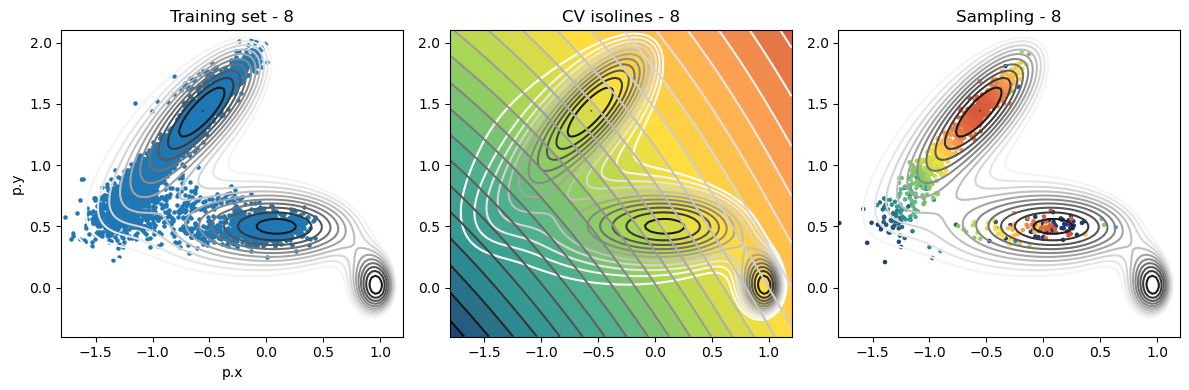

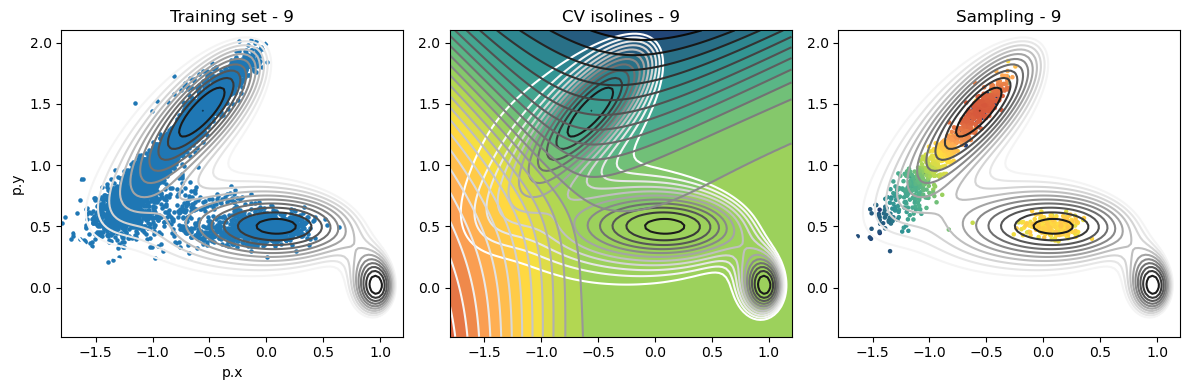

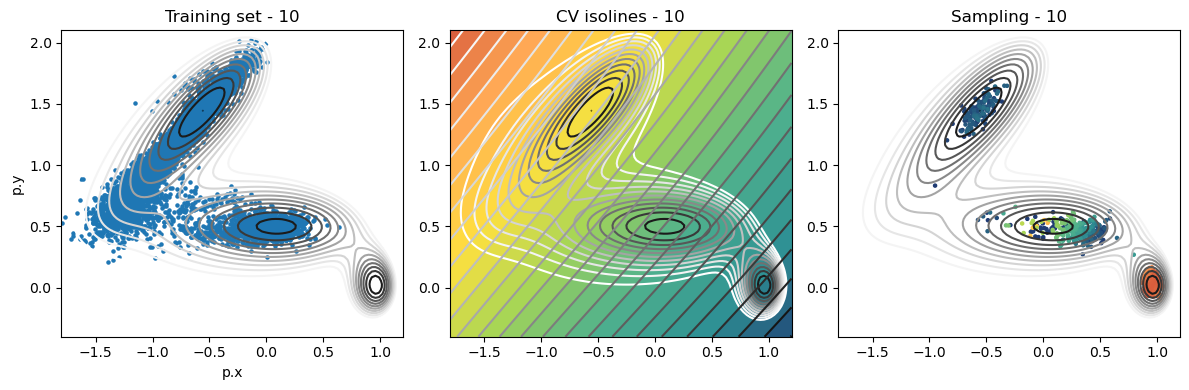

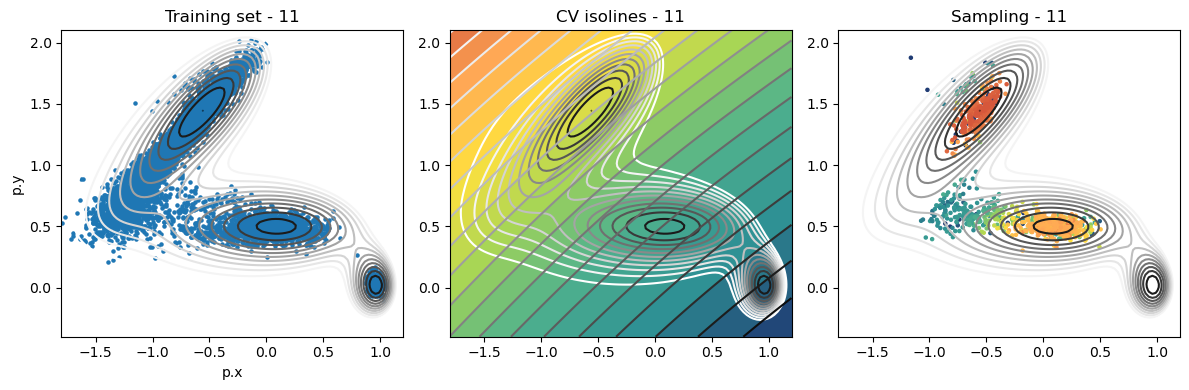

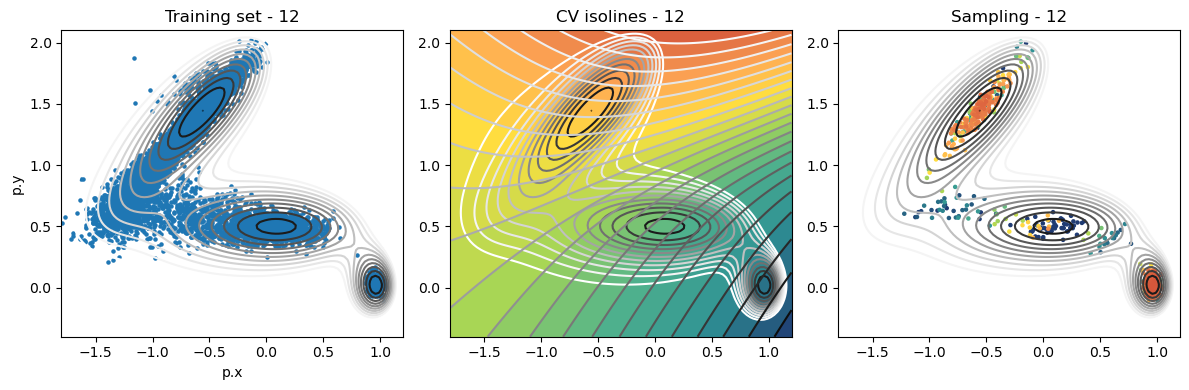

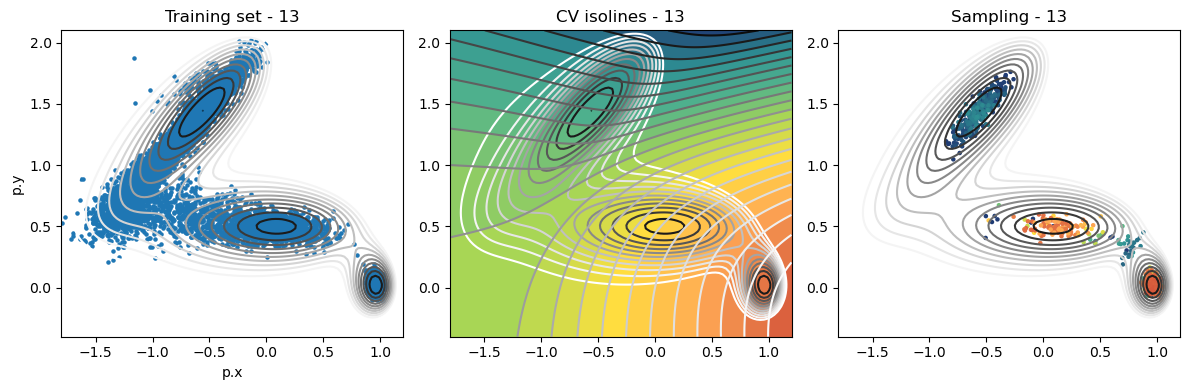

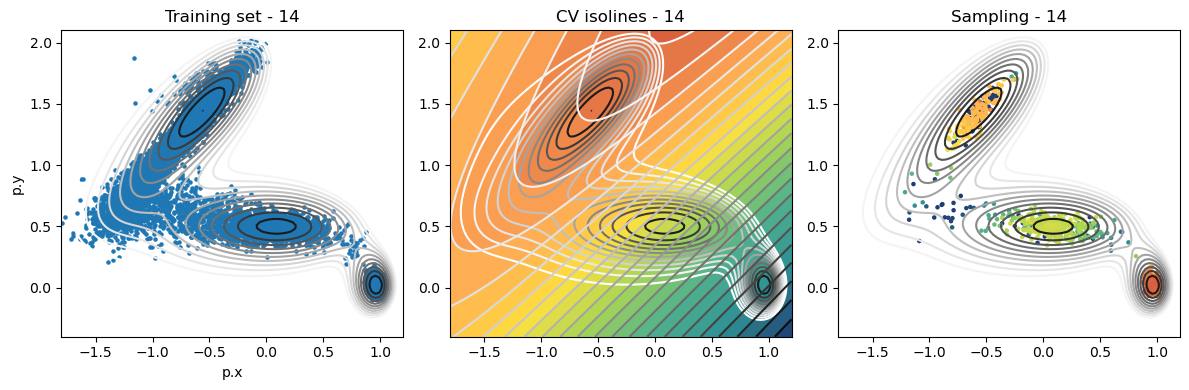

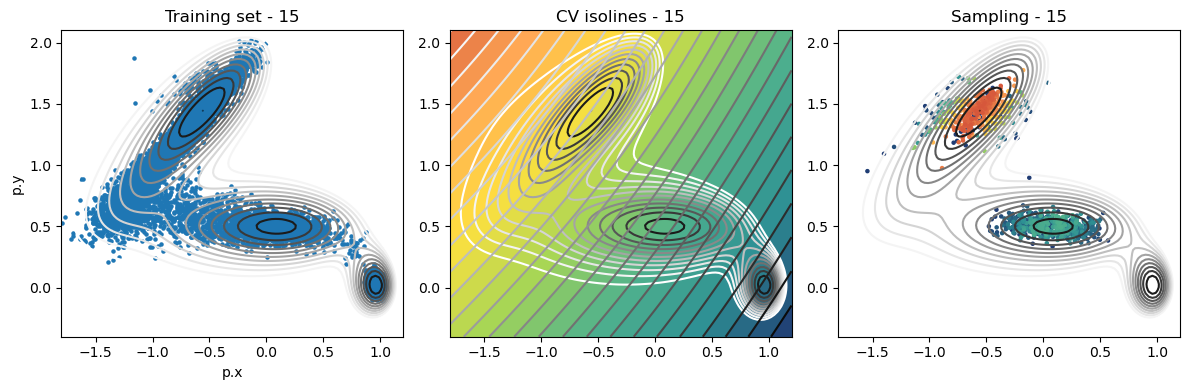

In [12]:
# set operation folder
RESULTS_FOLDER = 'results/unsupervised'
max_iter = 16
if run_calculations==False:
    for iter in range(max_iter):
        if iter == 0:
            training_data = load_dataframe(f'input_data/unsupervised/unbiased/COLVAR')
        else:
            training_data = load_training_data(iter)
        
        sampling_data = load_dataframe(f'{RESULTS_FOLDER}/iter_{iter}/data/COLVAR')
        plot_iter_summary(iter, train=training_data, sampling=sampling_data)
               
        
else:
    # subprocess.run(f"rm -r {RESULTS_FOLDER}", shell=True)
    # subprocess.run(f"mkdir {RESULTS_FOLDER}", shell=True)

    # procedure parameters
    use_all_data = True # keep all the previous data
    n_components = 1 # size of the latent space
    encoder_layers = [2,20,20,n_components]

    for iter in range(max_iter):
        # create folder for current iteration
        ITER_FOLDER = RESULTS_FOLDER+f'/iter_{iter}'
        subprocess.run(f"mkdir {ITER_FOLDER}", shell=True)

        if iter == 0:
            filenames = [f'input_data/unsupervised/unbiased/COLVAR']
        else:
            if use_all_data: 
                filenames = [f"{RESULTS_FOLDER}/iter_{i}/data/COLVAR" for i in range(iter) ]
            else:
                filenames = [f"{RESULTS_FOLDER}/iter_{iter-1}/data/COLVAR"]

        # 1 - Load and visualize unlabeled data
        datamodule, dataset, df = load_data(filenames)
        plot_training_points(df, ITER_FOLDER, iter)

        # 2 - Initialize model
        model = ae_model(encoder_layers)

        # 3 - Initialize trainer and train
        metrics = ae_trainer(model, datamodule, iter=iter)
        
        # 4 - Apply normalization on the output
        model = ae_normalization(model, dataset, n_components)
        
        # 5 - Export and visualize the model
        traced_model = model.to_torchscript(file_path=f'{ITER_FOLDER}/model_autoencoder_{iter}.pt', method='trace')
        ae_cv_isolines(model, n_components, ITER_FOLDER, iter)
        
        # 6 - RUM PLUMED simulation
        if iter == 0:
            initial_positions = '-0.7,1.4'
        else:
            initial_positions = f"{last_conf[0]},{last_conf[1]}"
        last_conf, SIMULATION_FOLDER = ae_run_plumed(iter, ITER_FOLDER, initial_position=initial_positions, nsteps=100000)
        ae_visualize_sampling(SIMULATION_FOLDER, iter)
    


## Analysis

findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.


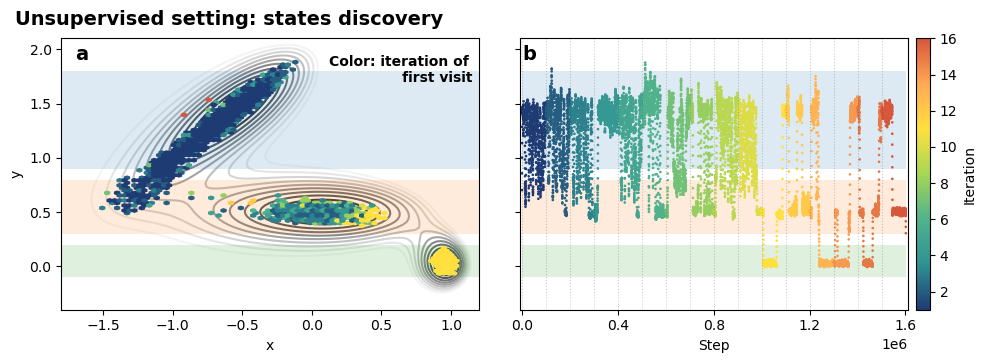

In [14]:
# load data
max_iter = 16
data = pd.DataFrame()
for i in range(0,max_iter,1):
    temp = load_dataframe(f'results/unsupervised/iter_{i}/data/COLVAR')
    temp['iter'] = i +1
    data = pd.concat((data, temp), ignore_index=True)

# create figure
fig, axs = plt.subplots(1,2,figsize=(10,3.5))

# panel A
ax = axs[0]
plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour', zorder=0, ax=ax, alpha=1)
cp = ax.hexbin(data['p.x'],data['p.y'],C=data['iter'],reduce_C_function= lambda x: np.min(x),cmap='fessa',mincnt=4,gridsize=80, zorder=5, alpha=1)

# labels
ax.set_xlabel('x')
ax.set_ylabel('y')
axs[0].text(0.12, 1.7, 'Color: iteration of\n               first visit', fontsize=10, fontweight='demi', font='ubuntu')

# shadow states reference
ax.fill_between(ax.get_xlim(), 0.9, 1.8,  alpha=0.15)
ax.fill_between(ax.get_xlim(), 0.3, 0.8,  alpha=0.15)
ax.fill_between(ax.get_xlim(), -0.1, 0.2, alpha=0.15)

# panel B
ax = axs[1]

# apply running average
data['tot_time'] = data.index*100
x= data['tot_time'] 
y= data['p.y']
N=10
y = np.convolve(y,np.ones(N)/N,mode='same')

# shadow states reference
ax.fill_between(np.linspace(0, x.values[-1]), 0.9, 1.8,  alpha=0.15)
ax.fill_between(np.linspace(0, x.values[-1]), 0.3, 0.8,  alpha=0.15)
ax.fill_between(np.linspace(0, x.values[-1]), -0.1, 0.2, alpha=0.15)

# plot time series
cp = ax.scatter(x,y,c=data['iter'], cmap='fessa', alpha=1, s=0.8)
cbar = plt.colorbar(cp, ax=ax, fraction=0.050, pad=0.02, format='%d')
cbar.set_label('Iteration',fontsize=10)


# labels
ax.set_xlabel('Step')
ax.set_ylim(-0.4,2.1)
ax.set_xlim(-1e4,max_iter*1e5+1e4)
ax.xaxis.set_ticks([0.0e6, 0.4e6, 0.8e6, 1.2e6, 1.6e6 ])
ax.yaxis.set_ticklabels([])

# iterations reference
for line in data.groupby('iter').min()['tot_time']:
    ax.axvline( line, color='k',alpha=0.2,linestyle='dotted', lw=0.8) 

# figure title
fig.text(0.02, 0.98, 'Unsupervised setting: states discovery', fontsize=14, fontweight='demi', font='ubuntu')
axs[0].text(-1.7, 1.9, 'a', fontsize=14, fontweight='demi', font='ubuntu')
axs[1].text(0, 1.9, 'b', fontsize=14, fontweight='demi', font='ubuntu')

# save figure
plt.tight_layout()
#plt.savefig('muller_experiments/figures/examples_unsupervised.png', dpi=200, bbox_inches='tight')
plt.show()